In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
#from torchsummary import summary

cudnn.benchmark = True
plt.ion()



e:\UDL Project\ad-venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [3]:
#apple
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Load Data

In [4]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = r"E:\UDL Project\anomaly-detection\data\capsule\train\good"
train_dataset = CustomDataset(data_dir,data_transforms)
test_dataset = CustomDataset(r"E:\UDL Project\anomaly-detection\data\capsule\test\crack",data_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader))

44 11


View Data

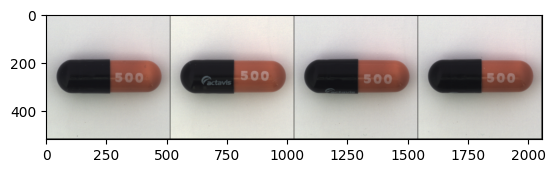

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [6]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*13*13, 2)
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 256*13*13),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [8]:
testModel = AutoEncoder()
#summary(testModel, (3, 512, 512),4)


Model, Loss & Optimizer

In [9]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.0001
num_epochs = 40

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train

In [10]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [11]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [12]:
def plot_ae_outputs(model,n=10):
  inputs = next(iter(val_dataloader))
  out = torchvision.utils.make_grid(inputs)
  imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training


 EPOCH 1/40 	 train loss 0.3631962537765503 	 val loss 0.32225334644317627


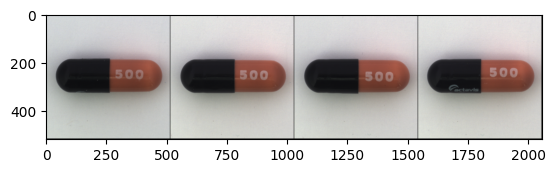

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


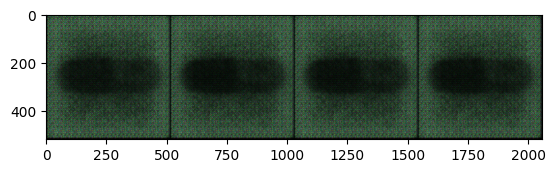


 EPOCH 2/40 	 train loss 0.29898354411125183 	 val loss 0.24660718441009521


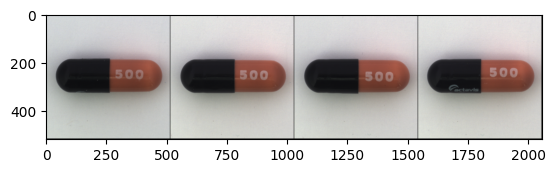

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


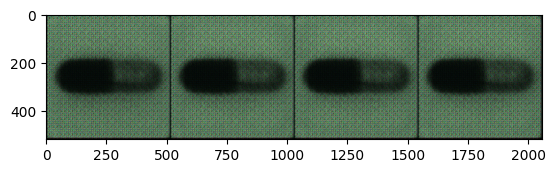


 EPOCH 3/40 	 train loss 0.23863692581653595 	 val loss 0.19515447318553925


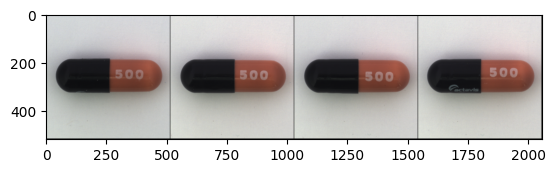

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


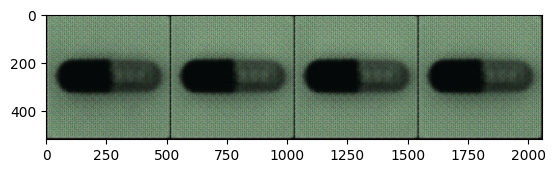


 EPOCH 4/40 	 train loss 0.16846784949302673 	 val loss 0.12187302857637405


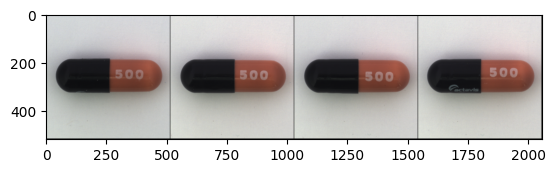

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


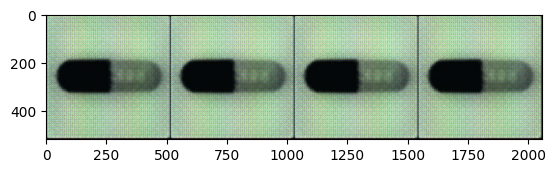


 EPOCH 5/40 	 train loss 0.07069220393896103 	 val loss 0.04726484417915344


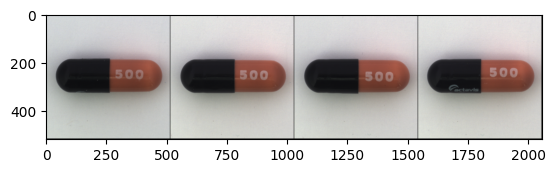

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


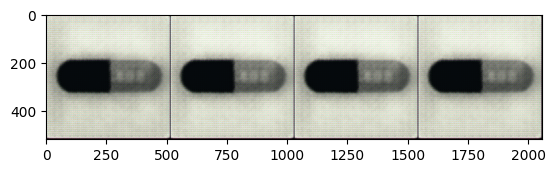


 EPOCH 6/40 	 train loss 0.02193896472454071 	 val loss 0.014116635546088219


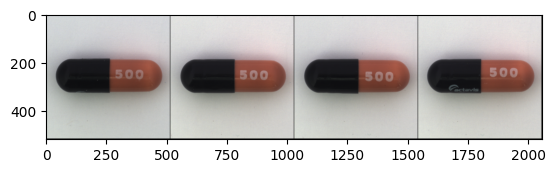

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


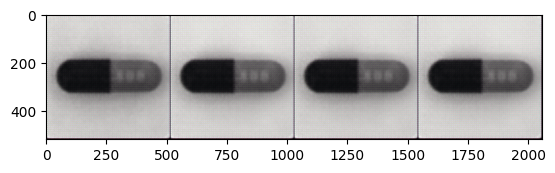


 EPOCH 7/40 	 train loss 0.010464341379702091 	 val loss 0.007948963902890682


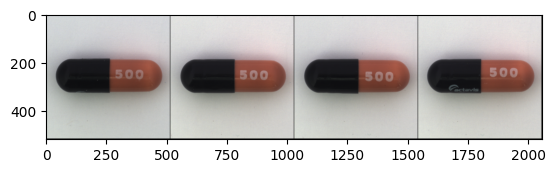

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


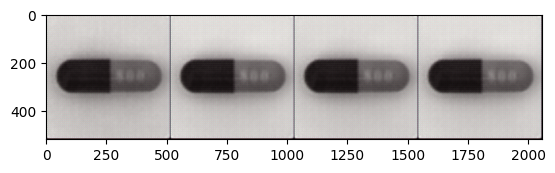


 EPOCH 8/40 	 train loss 0.006602957379072905 	 val loss 0.00541303027421236


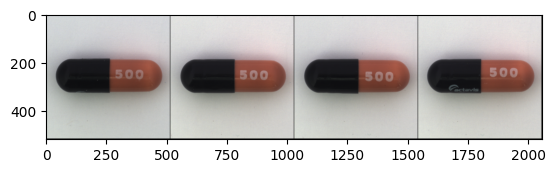

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


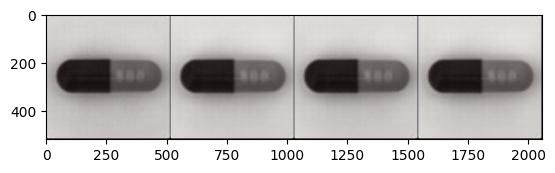


 EPOCH 9/40 	 train loss 0.004750503227114677 	 val loss 0.004363246262073517


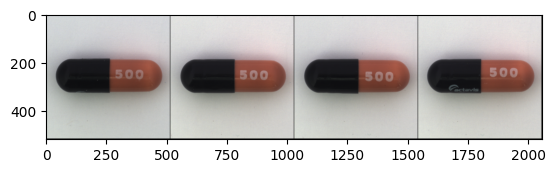

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


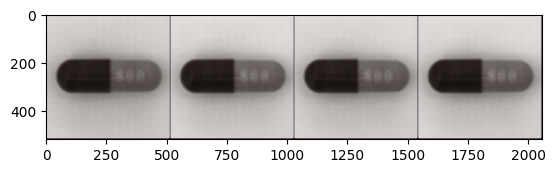


 EPOCH 10/40 	 train loss 0.0037524476647377014 	 val loss 0.003921494819223881


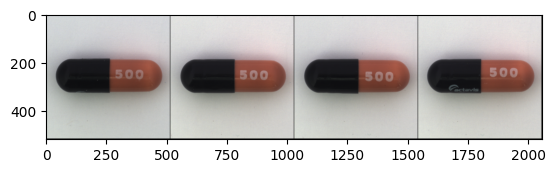

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


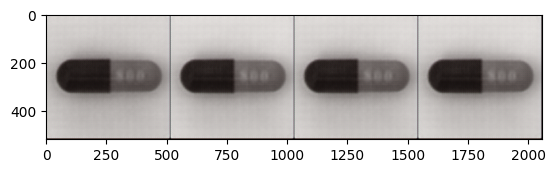


 EPOCH 11/40 	 train loss 0.003275110386312008 	 val loss 0.0036599363666027784


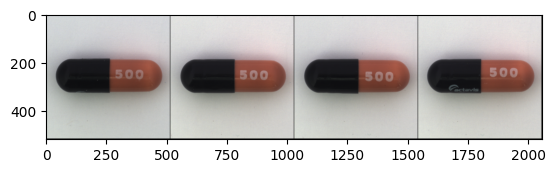

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


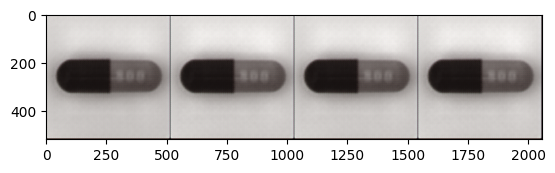


 EPOCH 12/40 	 train loss 0.002939514582976699 	 val loss 0.0033346733544021845


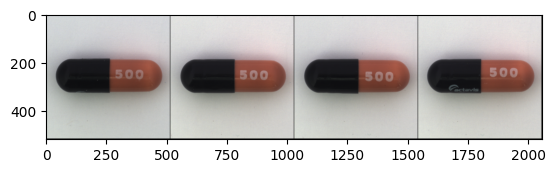

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


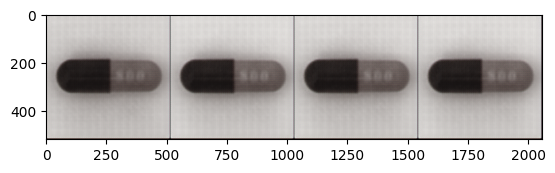


 EPOCH 13/40 	 train loss 0.002637488767504692 	 val loss 0.005079807713627815


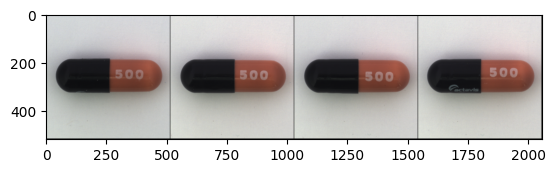

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


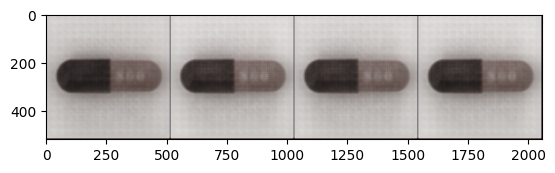


 EPOCH 14/40 	 train loss 0.0023165063466876745 	 val loss 0.0025248751044273376


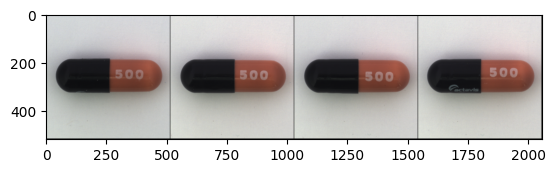

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


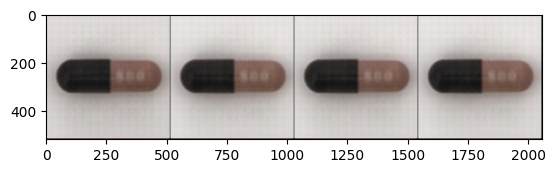


 EPOCH 15/40 	 train loss 0.0019002656918019056 	 val loss 0.00448827026411891


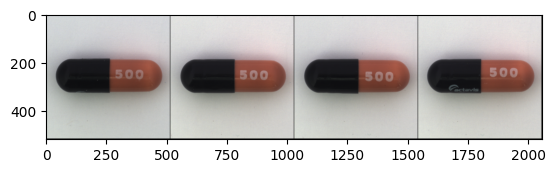

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


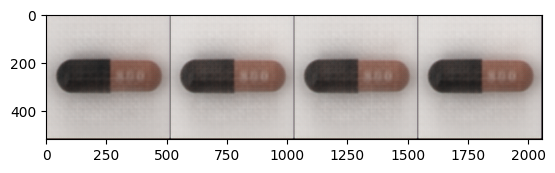


 EPOCH 16/40 	 train loss 0.0016132730524986982 	 val loss 0.014396007172763348


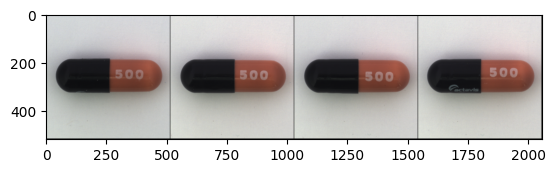

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


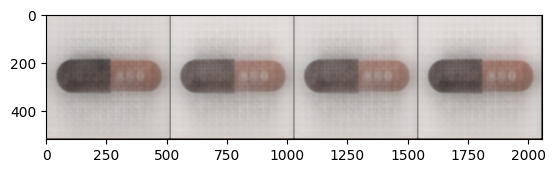


 EPOCH 17/40 	 train loss 0.0014572188956663013 	 val loss 0.0012671123258769512


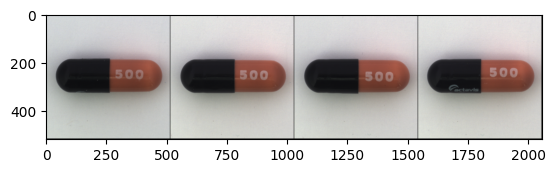

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


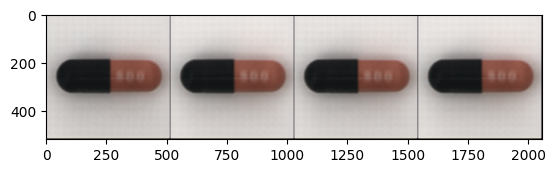


 EPOCH 18/40 	 train loss 0.0013271839125081897 	 val loss 0.004763869568705559


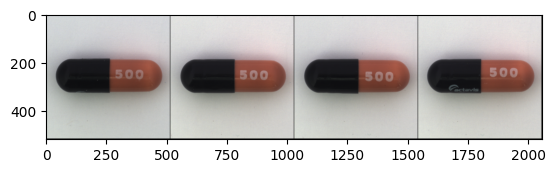

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


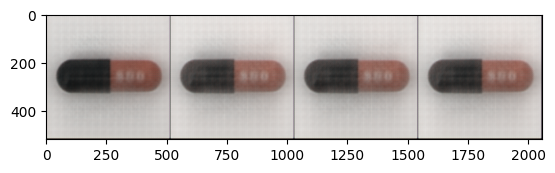


 EPOCH 19/40 	 train loss 0.001262727309949696 	 val loss 0.002864936599507928


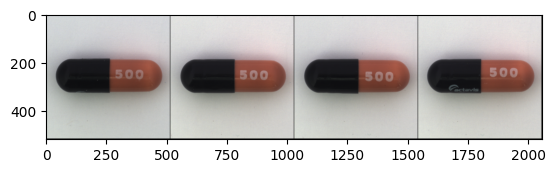

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


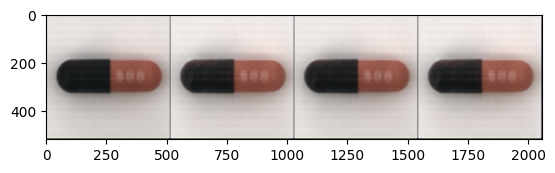


 EPOCH 20/40 	 train loss 0.0011975114466622472 	 val loss 0.028668934479355812


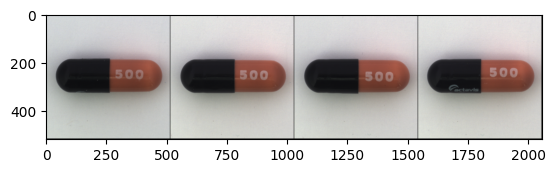

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


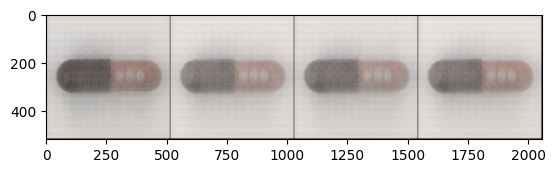


 EPOCH 21/40 	 train loss 0.001175210694782436 	 val loss 0.0035992974881082773


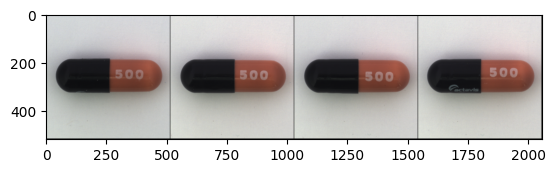

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


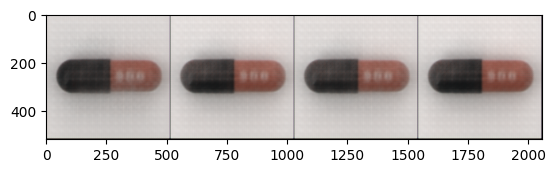


 EPOCH 22/40 	 train loss 0.0011067708255723119 	 val loss 0.033340614289045334


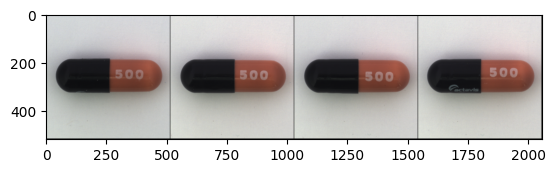

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


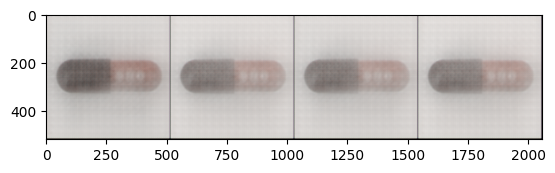


 EPOCH 23/40 	 train loss 0.0010606871219351888 	 val loss 0.013063756749033928


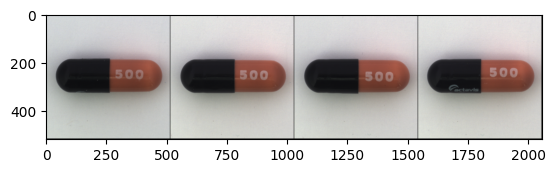

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


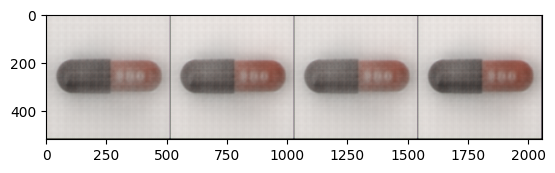


 EPOCH 24/40 	 train loss 0.001051972503773868 	 val loss 0.0008737216703593731


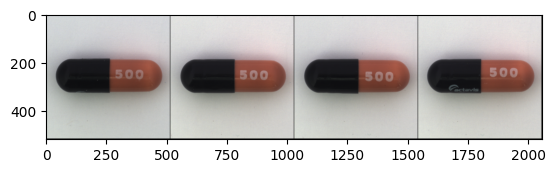

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


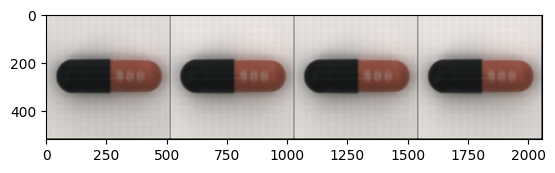


 EPOCH 25/40 	 train loss 0.0010835834546014667 	 val loss 0.001602274482138455


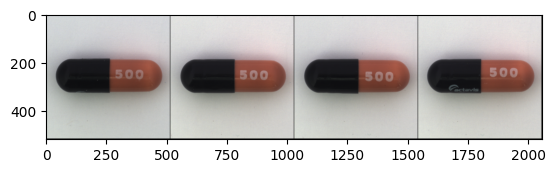

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


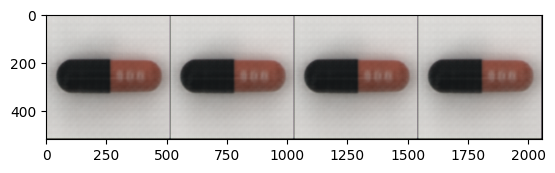


 EPOCH 26/40 	 train loss 0.0009804298169910908 	 val loss 0.005088407546281815


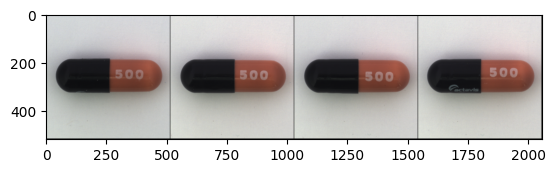

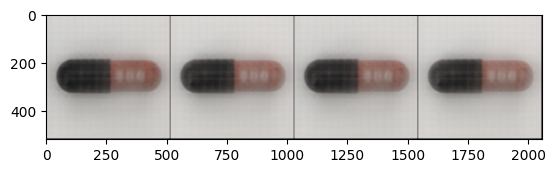


 EPOCH 27/40 	 train loss 0.0009706115815788507 	 val loss 0.006597300060093403


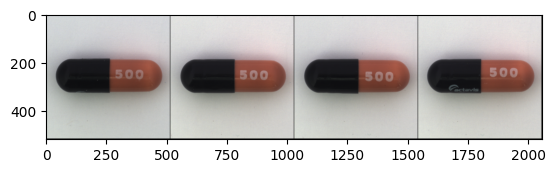

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


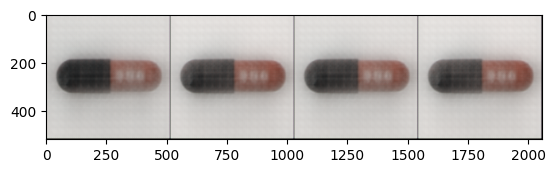


 EPOCH 28/40 	 train loss 0.000974329945165664 	 val loss 0.004470529966056347


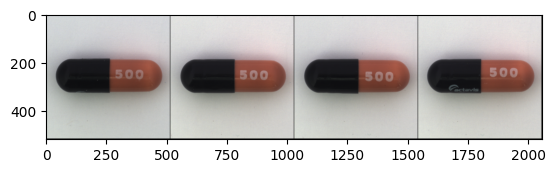

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


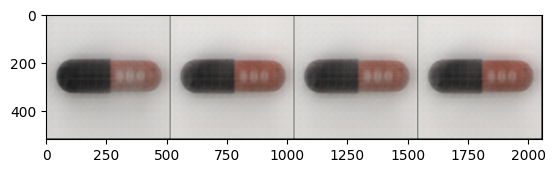


 EPOCH 29/40 	 train loss 0.000952554342802614 	 val loss 0.0008644892368465662


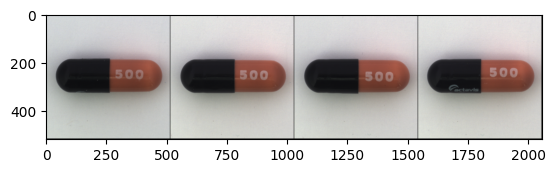

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


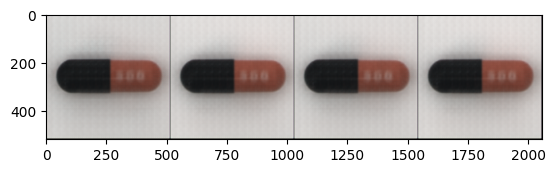


 EPOCH 30/40 	 train loss 0.0009612806607037783 	 val loss 0.006087135057896376


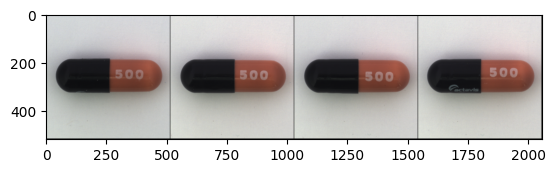

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


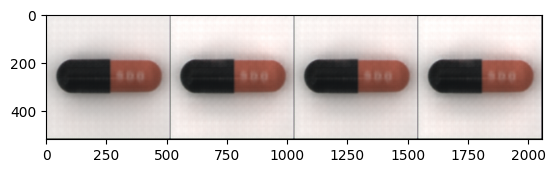


 EPOCH 31/40 	 train loss 0.0009568188106641173 	 val loss 0.0015868399059399962


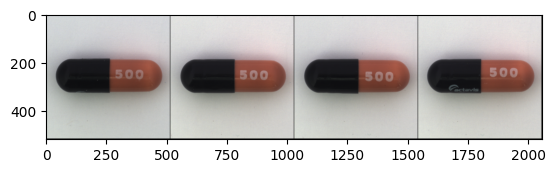

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


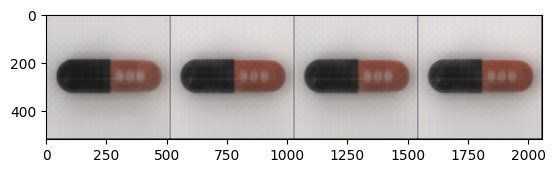


 EPOCH 32/40 	 train loss 0.0009691257146187127 	 val loss 0.0021768216975033283


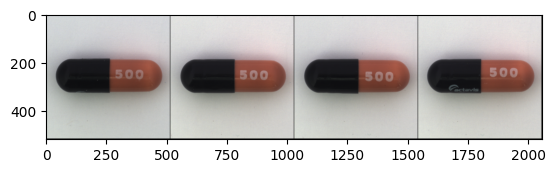

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


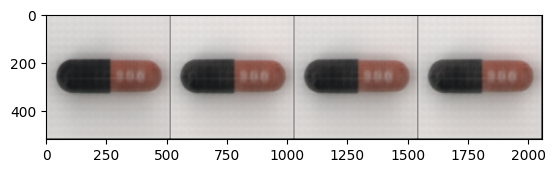


 EPOCH 33/40 	 train loss 0.0010269309859722853 	 val loss 0.0010784085607156157


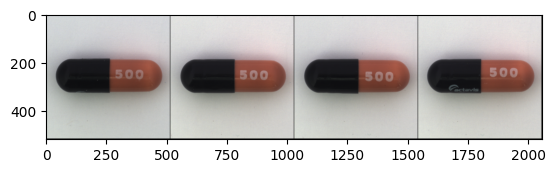

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


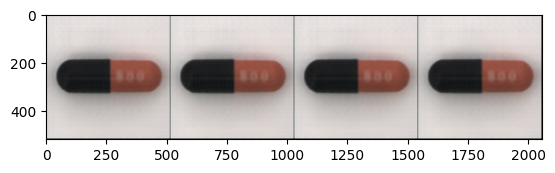

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 135266304 bytes.

In [13]:

diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Plot Validation loss vs Train Loss

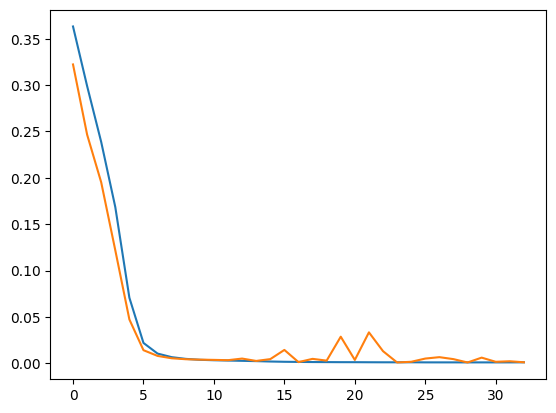

In [14]:
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.show()


Temp Section do not delete

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 512, 512])


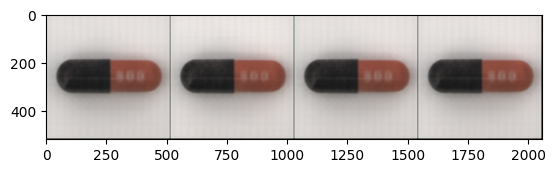

In [15]:
inputs = next(iter(train_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Latent Representation

In [16]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)
torch.set_printoptions(threshold=10_000)

C:\Users\Piyush Patil\AppData\Local\Temp\ipykernel_14028\3702266279.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1],cmap='hot')
C:\Users\Piyush Patil\AppData\Local\Temp\ipykernel_14028\3702266279.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot')
C:\Users\Piyush Patil\AppData\Local\Temp\ipykernel_14028\3702266279.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot')


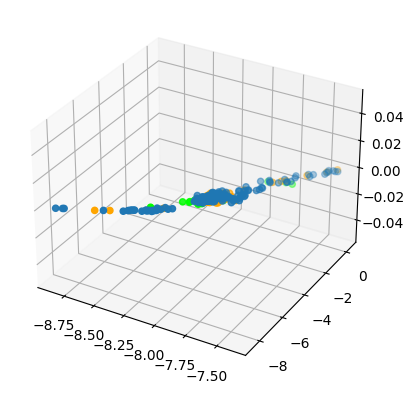

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(train[:, 0], train[:, 1],cmap='hot')
ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot')
ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot')

# Display the plot
plt.show()

In [19]:
with torch.no_grad():
        conc_out = []
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            conc_out.append(decoded_data.cpu())
        conc_out = torch.cat(conc_out)
print(conc_out)

tensor([[-7.5506, -0.8024],
        [-8.0291, -4.2002],
        [-7.8409, -3.2415],
        [-8.0141, -4.5551],
        [-7.9938, -4.6515],
        [-7.9823, -4.9042],
        [-7.9746, -4.4614],
        [-7.4494, -0.0933],
        [-7.9072, -4.5087],
        [-7.6459, -1.6534],
        [-7.9985, -4.7435],
        [-8.0340, -4.4478],
        [-8.0042, -4.4029],
        [-7.9530, -4.0794],
        [-8.5208, -7.5714],
        [-7.9533, -4.4200],
        [-8.2101, -6.2915],
        [-7.8168, -3.6578],
        [-7.8374, -4.1967],
        [-7.9247, -4.8013],
        [-7.9889, -4.9021],
        [-7.8731, -4.0096],
        [-7.7200, -2.0682],
        [-7.9504, -3.9178],
        [-7.8840, -4.0805],
        [-8.0102, -4.4838],
        [-7.3976,  0.3112],
        [-7.6725, -1.8092],
        [-7.8894, -4.2943],
        [-7.9756, -4.4379],
        [-7.9693, -4.9111],
        [-7.8219, -4.1995],
        [-8.0580, -5.0778],
        [-8.0255, -4.3306],
        [-7.9157, -4.7502],
        [-8.0249, -4